<a href="https://colab.research.google.com/github/7sr7/Projs-in-AI-HW-5-Redo/blob/main/Silvestre_Projs_in_AI_HW_5_Redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Silvestre Ronin

Professor Mushtaque

PROJECTS IN AI & MACHINE LRNG - CSCI 4170 - 01

2025 07 31

# Setup...

In [ ]:
# importing required libraries...
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
from wordcloud import WordCloud
from collections import Counter
from numpy import dot
from numpy.linalg import norm
import difflib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from numpy.linalg import norm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import tensorflow as tf
from collections import Counter
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
import dask.bag as db
import dask.array as da
from dask.diagnostics import ProgressBar
import random
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import copy
from torchvision import models
from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np


import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# mounting to google drive...
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Task1...


## Part1...

The dataset that I have chosen is the following:

https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

The task is a binary image classification problem

### Preprocessing Data...

In [ ]:
# reading data set...
data = "/content/drive/MyDrive/pizza_not_pizza/"

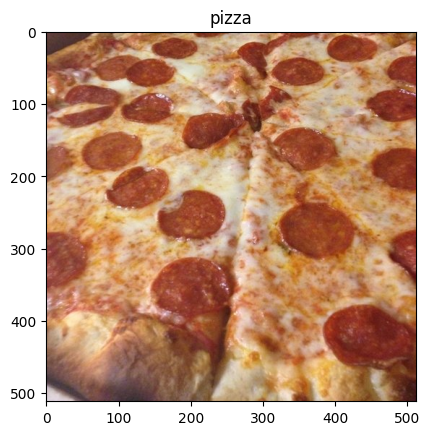

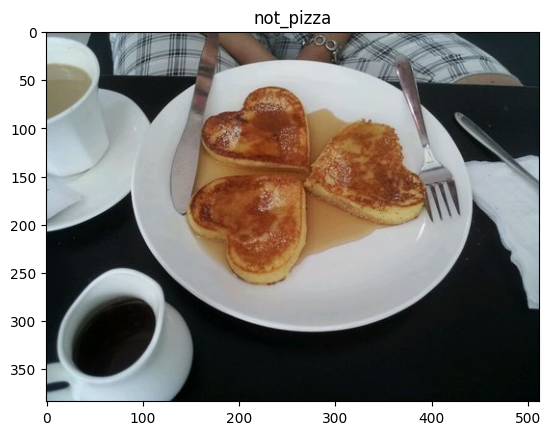

In [ ]:
# visualizing random sample of each class...
classes = ['pizza', 'not_pizza']
for cls in classes:
  folder = os.path.join(data, cls)
  sample = random.choice(os.listdir(folder))
  img = Image.open(os.path.join(folder, sample))
  plt.imshow(img)
  plt.title(cls)
  plt.show()

In [ ]:
# ('*.*') means that all image formats can be retrieved...
paths = [path.parts[-2:] for path in Path(data).rglob('*.*')]


# creating dataframe...
df = pd.DataFrame(data=paths, columns=['Class','Images'])
df = df.sort_values('Class',ascending=True)
df.reset_index(drop=True, inplace=True)

df

,Class,Images
0,not_pizza,99088.jpg
1,not_pizza,240787.jpg
2,not_pizza,2354658.jpg
3,not_pizza,2438063.jpg
4,not_pizza,215349.jpg
...,...,...
1961,pizza,3441394.jpg
1962,pizza,3550805.jpg
1963,pizza,3456604.jpg
1964,pizza,3678290.jpg


In [ ]:
# printing numerical stats about the data...
print(f"Total Images: {len(df.Images)}")
print(f"Total Classes: {len(df['Class'].value_counts())} \n")


print('Total Number of Images in Each Class')
print(df['Class'].value_counts())

Total Images: 1966
Total Classes: 2 

Total Number of Images in Each Class
Class
not_pizza    983
pizza        983
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

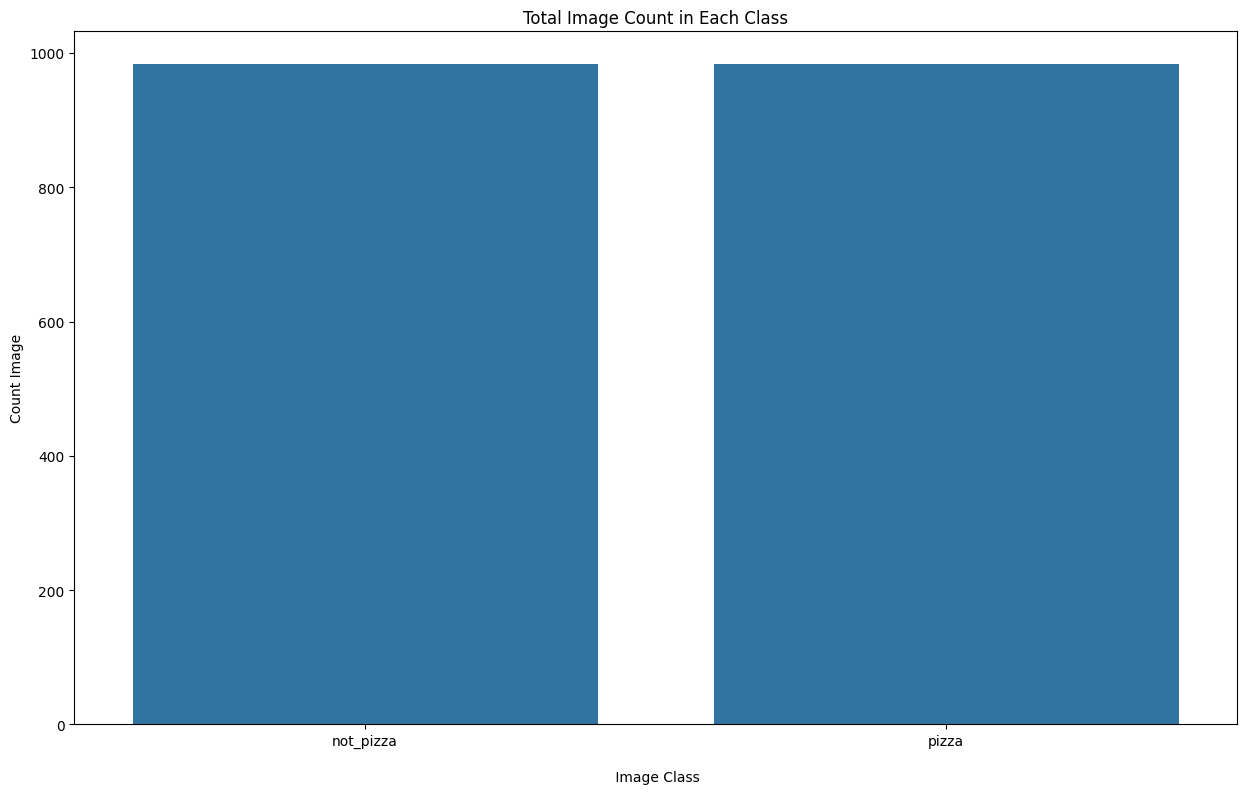

In [ ]:
# plotting total number of images in each class
# visually shows us if data is balanced or not...
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Total Image Count in Each Class')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

In [ ]:
directories = {
    "not_pizza": "/content/drive/MyDrive/pizza_not_pizza/not_pizza/",
    "pizza": "/content/drive/MyDrive/pizza_not_pizza/pizza/"
}

def getDims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

[########################################] | 100% Completed | 40.97 s
[########################################] | 100% Completed | 52.53 s


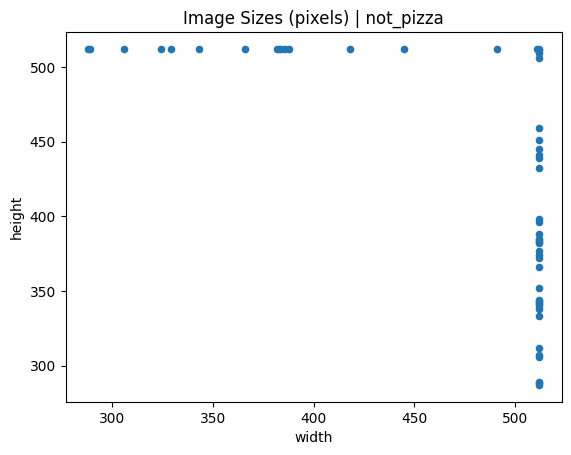

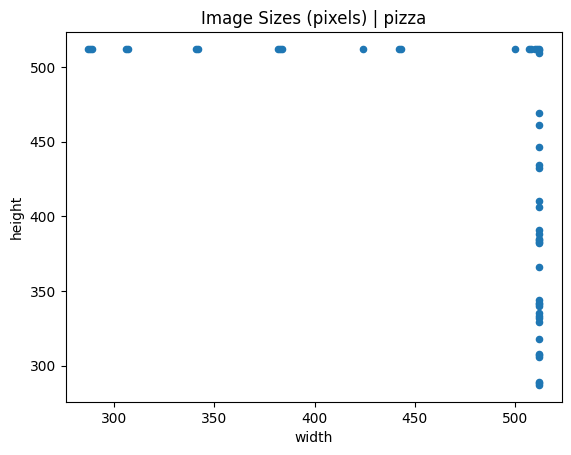

In [ ]:
# plotting image dimensions for each class...
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = db.from_sequence(filelist).map(getDims)

  with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

In [ ]:
# we observe from the above graphs that our images are not all the same dimensions
# we need them to be in order to feed them into our CNN
# so, we need to resize all of them to a consistent size...

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=data, transform=transform)

In [ ]:
# calculating mean and stdev px vals of each img to be used in normalization...

all_pixels = torch.cat([img for img, _ in dataset], dim=1)
imgMean = all_pixels.mean().item()
imgStd = all_pixels.std().item()
print(f"Mean: {imgMean}, Std: {imgStd}")

Mean: 0.43468132615089417, Std: 0.2694951593875885


In [ ]:
# adding normalization now...

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[imgMean], std=[imgStd])
])
dataset = datasets.ImageFolder(root=data, transform=transform)

In [ ]:
# creating dataloader object from dataset...

loader = DataLoader(dataset, batch_size=64, shuffle=True)
images, labels = next(iter(loader))

# sanity check to make sure that all imgs are same size...
# 3 means that we have 3 dimensions of r,g,b...
print("Batch shape:", images.shape)

Batch shape: torch.Size([64, 3, 64, 64])


In [ ]:
# train, val, test split on data... i am choosing a 80 10 10 split
trainSize = int(0.8 * len(dataset))
valSize = int(0.1 * len(dataset))
testSize = len(dataset) - trainSize - valSize

trainSet, valSet, testSet = random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
# creating dataloader for train, val, and test sets...
trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
valLoader = DataLoader(valSet, batch_size=64, shuffle=False)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False)

In [ ]:
# sanity check...
images, labels = next(iter(trainLoader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])

Batch shape: torch.Size([64, 3, 64, 64])
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1])


### Making the CNN...

The architecture that I have gone with is the following:

2 convolution layers
- 32, 64 filters
- convolution dropout: 0.2


2 fc layers
- 32 hidden size, 1 output layer
- dropout: 0.5

max pooling used
RELU activation used (non final fc layer(s))

early stopping implemented


I didn't have too many convolution and fc layers, as well as the size of each layer wasn't very big. The main reason for this was because running my model took a significant amount of my time, given the fact that I don't have a designated GPU to run this code. Additionally. my dataset was relatively small (2k images) and I had downscaled the pixels as well to save time for training, so that also factored into my decision to have a shallower network.

To prevent overfitting, I used dropout and early stopping.

In [ ]:
# CNN declaration...
class myCNN(nn.Module):
  def __init__(self):
    super(myCNN, self).__init__()
    # defining convolutoin layers and pooling...

    # first conv layer - takes as input: 3 x 64 x 64 (depth of 3 since this is rgb and not grayscale)
    self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding=1)

    # 3 x 64 x 64 --> 32 x 64 x 64 (apply 1st conv) --> 32 z 32 x 32 (max pooling)

    # second conv layer - takes as input: 32 x 32 x 32
    self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)

    # 32 x 32 x 32 --> 64 x 32 x 32 (apply 2nd conv) --> 64 x 16 x 16 (max pooling)

    # 3rd conv layer - takes as input 64 x 16 x 16
    if False:
      self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)

    # 64 x 16 x 16 --> 128 x 16 x 16 (apply 3rd conv) --> 128 x 8 x 8 (max pooling)

    # to help with overfitting...
    self.dropout = nn.Dropout(0.5)
    self.conv_dropout = nn.Dropout2d(0.2)

    self.pool = nn.MaxPool2d(2, 2)



    # defining the regular NN after flattening...
    # so input to this NN now is 128 * 8 * 8 (we flatten), hidden layer is size 128
    if False:
      self.fc1 = nn.Linear(128 * 8 * 8, 32)
    else:
      self.fc1 = nn.Linear(64 * 16 * 16, 32)


    # hidden layer to output layer is 128 to 1 (since this si binary classification)
    self.fc2 = nn.Linear(32, 1)


  # i have chosen to use relu as my nonlinear activation and then to apply sigmoid
  # as my final activation (+ BCELoss) since this is a binary classificaiton problem
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.conv_dropout(x)

    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv_dropout(x)


    if False:
      x = self.pool(F.relu(self.conv3(x)))
      x = self.conv_dropout(x)


    x = x.view(x.size(0), -1)


    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = self.fc2(x)
    # x = self.dropout(x)
    x = torch.sigmoid(x)

    return x


In [ ]:
# CNN initialization...
model = myCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
numEpochs = 5

In [ ]:
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_index = -1
patience = 3
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(numEpochs):
  # training...
  model.train()
  correct = 0
  total = 0
  total_train_loss = 0

  for images, labels in trainLoader:
    labels = labels.float().unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

    preds = (outputs >= 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  acc = correct / total
  avg_train_loss = total_train_loss / len(trainLoader)
  train_losses.append(avg_train_loss)


  print(f"Epoch {epoch+1}/{numEpochs}:")
  print(f"Train Loss: {avg_train_loss:.4f} — Train Acc: {acc:.4f}")


  # validation...
  model.eval()
  val_correct = 0
  val_total = 0
  total_val_loss = 0

  y_true = []
  y_pred = []
  with torch.no_grad():
    for images, labels in valLoader:
      labels = labels.float().unsqueeze(1)

      outputs = model(images)
      loss = criterion(outputs, labels)

      preds = (outputs >= 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

      total_val_loss += loss.item()


  avg_val_loss = total_val_loss / len(valLoader)
  val_losses.append(avg_val_loss)

  val_acc = val_correct / val_total

  print(f"Val Loss: {avg_val_loss:.4f} — Val Acc: {val_acc:.4f}\n")

  # print("Confusion Matrix:")
  # cm = confusion_matrix(y_true, y_pred)
  # print(cm)

  # print("\nEvaluation Metrics:")
  # print(classification_report(y_true, y_pred))
  print("\n\n")


  # early stopping to prevent overfitting...
  if (avg_val_loss < best_val_loss):
    best_val_loss = avg_val_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_index = epoch + 1

    # reset...
    trigger_times = 0

  else:
    print("Here...")
    trigger_times += 1
    if trigger_times >= patience:
      print("Early stopping triggered... loading best weights...")
      break


model.load_state_dict(best_model_wts)
print(f"Best Weights at index {best_index} with a validation loss of {best_val_loss}")

Epoch 1/5:
Train Loss: 0.6841 — Train Acc: 0.5789
Val Loss: 0.6852 — Val Acc: 0.5918




Epoch 2/5:
Train Loss: 0.6579 — Train Acc: 0.6209
Val Loss: 0.6615 — Val Acc: 0.6378




Epoch 3/5:
Train Loss: 0.6340 — Train Acc: 0.6425
Val Loss: 0.6118 — Val Acc: 0.6837




Epoch 4/5:
Train Loss: 0.6163 — Train Acc: 0.6565
Val Loss: 0.5938 — Val Acc: 0.7143




Epoch 5/5:
Train Loss: 0.6006 — Train Acc: 0.6959
Val Loss: 0.5732 — Val Acc: 0.7143




Best Weights at index 5 with a validation loss of 0.5731678754091263


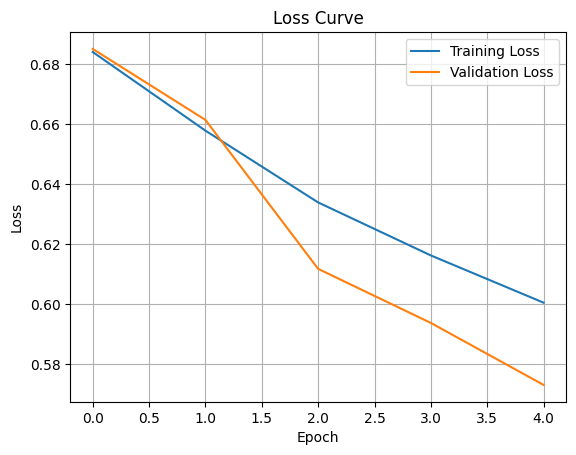

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# testing...
model.eval()

test_correct = 0
test_total = 0
total_test_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in testLoader:
    labels = labels.float().unsqueeze(1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    preds = (outputs >= 0.5).float()
    test_correct += (preds == labels).sum().item()
    test_total += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(testLoader)
test_acc = test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f} — Test Acc: {test_acc:.4f}\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# [[TN  FP]
#  [FN  TP]]

print("\nEvaluation Metrics:")
print(classification_report(y_true, y_pred))

Test Loss: 0.5715 — Test Acc: 0.7273

Confusion Matrix:
[[77 16]
 [38 67]]

Evaluation Metrics:
              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74        93
         1.0       0.81      0.64      0.71       105

    accuracy                           0.73       198
   macro avg       0.74      0.73      0.73       198
weighted avg       0.74      0.73      0.73       198



Analysis...

The metrics used were test accuracy, confusion matrix, and a classification report that consisted of precision, recall, f1-score, and support.

From the above cell, we observe that test accuracy was ~73%. Additionally, we see that we predicted more true negatives than true positives, yet struggled more with false negatives than false positives. This overall suggests that my model tended to predict more negatives than positives.

## Part2: Using ResNet50...

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
print(model.fc)
# exit(1)

num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()  # for BCELoss
)

Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head
for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
resNetTransform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),

    # standard ImageNet normalization...
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

resDataset = datasets.ImageFolder(root=data, transform=resNetTransform)

trainResSize = int(.8 * len(resDataset))
valResSize = int(.1 * len(resDataset))
testResSize = len(resDataset) - trainResSize - valResSize


trainResSet, valResSet, testResSet = random_split(resDataset, [trainResSize, valResSize, testResSize])
trainResLoader = DataLoader(trainResSet, batch_size=64, shuffle=True)
valResLoader = DataLoader(valResSet, batch_size=64, shuffle=False)
testResLoader = DataLoader(testResSet, batch_size=64, shuffle=False)

In [ ]:
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_index = -1
patience = 3
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

numEpochs = 5

for epoch in range(numEpochs):
  # training...
  model.train()
  correct = 0
  total = 0
  total_train_loss = 0

  for images, labels in trainResLoader:
    labels = labels.float().unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

    preds = (outputs >= 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  acc = correct / total
  avg_train_loss = total_train_loss / len(trainResLoader)
  train_losses.append(avg_train_loss)


  print(f"Epoch {epoch+1}/{numEpochs}:")
  print(f"Train Loss: {avg_train_loss:.4f} — Train Acc: {acc:.4f}")


  # validation...
  model.eval()
  val_correct = 0
  val_total = 0
  total_val_loss = 0

  y_true = []
  y_pred = []
  with torch.no_grad():
    for images, labels in valResLoader:
      labels = labels.float().unsqueeze(1)

      outputs = model(images)
      loss = criterion(outputs, labels)

      preds = (outputs >= 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

      total_val_loss += loss.item()


  avg_val_loss = total_val_loss / len(valResLoader)
  val_losses.append(avg_val_loss)

  val_acc = val_correct / val_total

  print(f"Val Loss: {avg_val_loss:.4f} — Val Acc: {val_acc:.4f}\n")

  # print("Confusion Matrix:")
  # cm = confusion_matrix(y_true, y_pred)
  # print(cm)

  # print("\nEvaluation Metrics:")
  # print(classification_report(y_true, y_pred))
  print("\n\n")


  # early stopping to prevent overfitting...
  if (avg_val_loss < best_val_loss):
    best_val_loss = avg_val_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_index = epoch + 1

    # reset...
    trigger_times = 0

  else:
    print("Here...")
    trigger_times += 1
    if trigger_times >= patience:
      print("Early stopping triggered... loading best weights...")
      break


model.load_state_dict(best_model_wts)
print(f"Best Weights at index {best_index} with a validation loss of {best_val_loss}")

Epoch 1/5:
Train Loss: 0.3963 — Train Acc: 0.8486
Val Loss: 0.3762 — Val Acc: 0.8520




Epoch 2/5:
Train Loss: 0.3306 — Train Acc: 0.8830
Val Loss: 0.3353 — Val Acc: 0.8980




Epoch 3/5:
Train Loss: 0.2972 — Train Acc: 0.8963
Val Loss: 0.3184 — Val Acc: 0.9133




Epoch 4/5:
Train Loss: 0.2833 — Train Acc: 0.8976
Val Loss: 0.3138 — Val Acc: 0.8827




Epoch 5/5:
Train Loss: 0.3099 — Train Acc: 0.8670
Val Loss: 0.2830 — Val Acc: 0.8980




Best Weights at index 5 with a validation loss of 0.2829611599445343


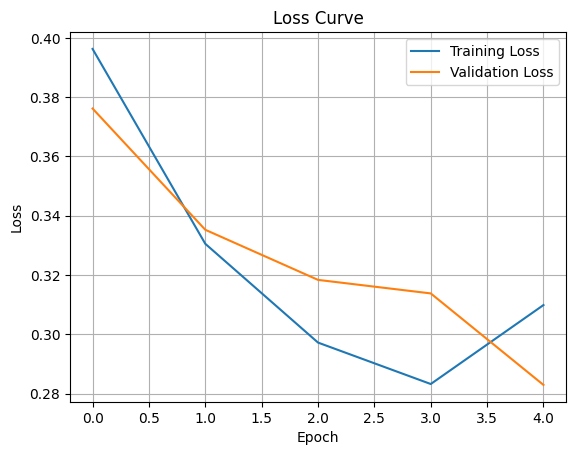

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# testing...
model.eval()

test_correct = 0
test_total = 0
total_test_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in testResLoader:
    labels = labels.float().unsqueeze(1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    preds = (outputs >= 0.5).float()
    test_correct += (preds == labels).sum().item()
    test_total += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(testResLoader)
test_acc = test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f} — Test Acc: {test_acc:.4f}\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# [[TN  FP]
#  [FN  TP]]

print("\nEvaluation Metrics:")
print(classification_report(y_true, y_pred))

Test Loss: 0.2376 — Test Acc: 0.9192

Confusion Matrix:
[[89  8]
 [ 8 93]]

Evaluation Metrics:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        97
         1.0       0.92      0.92      0.92       101

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



Analysis...

My evaluation metrics that I used for Part 1 and Part 2 was test accuracy, confusion matrix, and classification report so that I could view the precision, recall, etc.


For the model that I built from scratch in Part 1, it had a test accuracy of ~72%. On the other hand, the ResNet50 model that I used in Part 2 had a test accuracy of ~92%. This is noticeably higher than my results. Across all other metrics, the ResNet50 model did noticeably better.

One reason for why ResNet may have been significantly better is due to how much "deeper" its network is. ResNet has 50 layers, while mine only has a couple mainly due to resource constraints.

In addition, in order to combat overfitting, I only use dropout and early stopping, while ResNet implements more advanced techniques such as skip connects which helps with architectural regularization.

These 2 main reasons may have lead to the ResNet model being able to learn more complex / abstract features, and thus, help it to better generalize and learn my data than my own model.

## Part3: Data Augmentation

In [ ]:
dataAug = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),   # randomly flip images
  transforms.RandomRotation(20),            # randomly rotate ±20 degrees
  transforms.ColorJitter(brightness=0.2, contrast=0.2), # optional color variation
  transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.5]*3)
])

datasetAug = datasets.ImageFolder(root=data, transform=dataAug)

trainAugSize = int(.8 * len(datasetAug))
valAugSize = int(.1 * len(datasetAug))
testAugSize = len(datasetAug) - trainAugSize - valAugSize


trainAugSet, valAugSet, testAugSet = random_split(datasetAug, [trainAugSize, valAugSize, testAugSize])
trainAugLoader = DataLoader(trainAugSet, batch_size=64, shuffle=True)
valAugLoader = DataLoader(valAugSet, batch_size=64, shuffle=False)
testAugLoader = DataLoader(testAugSet, batch_size=64, shuffle=False)



In [ ]:
# CNN initialization...
model = myCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
numEpochs = 5
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_index = -1
patience = 3
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())


for epoch in range(numEpochs):
  # training...
  model.train()
  correct = 0
  total = 0
  total_train_loss = 0

  for images, labels in trainAugLoader:
    labels = labels.float().unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

    preds = (outputs >= 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  acc = correct / total
  avg_train_loss = total_train_loss / len(trainAugLoader)
  train_losses.append(avg_train_loss)


  print(f"Epoch {epoch+1}/{numEpochs}:")
  print(f"Train Loss: {avg_train_loss:.4f} — Train Acc: {acc:.4f}")


  # validation...
  model.eval()
  val_correct = 0
  val_total = 0
  total_val_loss = 0

  y_true = []
  y_pred = []
  with torch.no_grad():
    for images, labels in valAugLoader:
      labels = labels.float().unsqueeze(1)

      outputs = model(images)
      loss = criterion(outputs, labels)

      preds = (outputs >= 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

      total_val_loss += loss.item()


  avg_val_loss = total_val_loss / len(valAugLoader)
  val_losses.append(avg_val_loss)

  val_acc = val_correct / val_total

  print(f"Val Loss: {avg_val_loss:.4f} — Val Acc: {val_acc:.4f}\n")

  # print("Confusion Matrix:")
  # cm = confusion_matrix(y_true, y_pred)
  # print(cm)

  # print("\nEvaluation Metrics:")
  # print(classification_report(y_true, y_pred))
  print("\n\n")


  # early stopping to prevent overfitting...
  if (avg_val_loss < best_val_loss):
    best_val_loss = avg_val_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_index = epoch + 1

    # reset...
    trigger_times = 0

  else:
    print("Here...")
    trigger_times += 1
    if trigger_times >= patience:
      print("Early stopping triggered... loading best weights...")
      break


model.load_state_dict(best_model_wts)
print(f"Best Weights at index {best_index} with a validation loss of {best_val_loss}")

Epoch 1/5:
Train Loss: 0.6857 — Train Acc: 0.5585
Val Loss: 0.7001 — Val Acc: 0.5816




Epoch 2/5:
Train Loss: 0.6546 — Train Acc: 0.6323
Val Loss: 0.6866 — Val Acc: 0.7041




Epoch 3/5:
Train Loss: 0.6359 — Train Acc: 0.6457
Val Loss: 0.7009 — Val Acc: 0.7296




Here...
Epoch 4/5:
Train Loss: 0.6254 — Train Acc: 0.6737
Val Loss: 0.7173 — Val Acc: 0.6786




Here...
Epoch 5/5:
Train Loss: 0.6151 — Train Acc: 0.6686
Val Loss: 0.7397 — Val Acc: 0.7194




Here...
Early stopping triggered... loading best weights...
Best Weights at index 2 with a validation loss of 0.6866199225187302


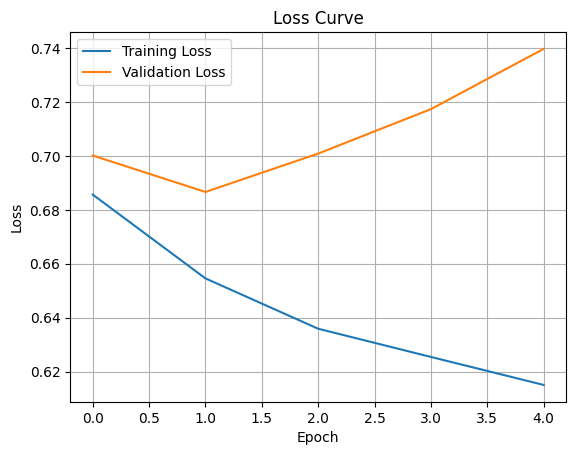

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# testing...
model.eval()

test_correct = 0
test_total = 0
total_test_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in testAugLoader:
    labels = labels.float().unsqueeze(1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    preds = (outputs >= 0.5).float()
    test_correct += (preds == labels).sum().item()
    test_total += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(testAugLoader)
test_acc = test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f} — Test Acc: {test_acc:.4f}\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# [[TN  FP]
#  [FN  TP]]

print("\nEvaluation Metrics:")
print(classification_report(y_true, y_pred))

Test Loss: 0.6461 — Test Acc: 0.6616

Confusion Matrix:
[[73 39]
 [28 58]]

Evaluation Metrics:
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.69       112
         1.0       0.60      0.67      0.63        86

    accuracy                           0.66       198
   macro avg       0.66      0.66      0.66       198
weighted avg       0.67      0.66      0.66       198



Analysis...

Yes, I observed differnences in my results from Part 1 when implementing data augmentation. Implementing the same metrics for both, I notice that for Part 1, my test accuracy was ~72%, whereas with data augmentation, it drops to ~66%. This is not a major drop in accuracy, but it suggests that data augmentation wasn't particularly too helpful in increasing total accuracy.

One main reason for this could be because of how shallow my model is. Even with introducing data augmentation to add complexity, my model may have been too shallow to truly get the benefits of this strategy and thus, did not learn all the complexity that it could have.


---
# Task2...

## Part1: Making the VAE...

In [ ]:
vae_transform = transforms.Compose([
  # resizing to 32 x 32 just to help with training faster....
  transforms.Resize((32, 32)),
  transforms.ToTensor()
])

vae_dataset = datasets.ImageFolder(root=data, transform=vae_transform)

vae_train, vae_val, vae_test = random_split(vae_dataset, [trainSize, valSize, testSize])
vae_train_loader = DataLoader(vae_train, batch_size=16, shuffle=True)
vae_val_loader = DataLoader(vae_val, batch_size=16, shuffle=False)
vae_test_loader = DataLoader(vae_test, batch_size=16, shuffle=False)


In [ ]:
# VAE Intialization...
class VAE(nn.Module):
  def __init__(self, latent_dim=128):
    super(VAE, self).__init__()
    # encoder...

    # 32 x 32 --> 16 x 16
    self.enc_conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)

    # 16 x 16 --> 8 x 8
    self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)


    self.flatten_dim = 64 * 8 * 8

    self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
    self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)


    # decoder...
    self.fc_dec = nn.Linear(latent_dim, self.flatten_dim)

    # 8 x 8 --> 16 x 16
    self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)

    # 16 x 16 --> 32 x 32
    self.dec_deconv2 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)


  # takse input and turns it into a gaussian distribution...
  def encode(self, x):
    # nonlinear activation used is relu...
    x = F.relu(self.enc_conv1(x))
    x = F.relu(self.enc_conv2(x))

    if False:
      x = F.relu(self.enc_conv3(x))


    x = x.view(x.size(0), -1)

    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)

    return mu, logvar


  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)

    return mu + eps * std


  # samples from the encoder's output distribution and reconstructs...
  def decode(self, z):
    x = F.relu(self.fc_dec(z))
    x = x.view(-1, 64, 8, 8)

    x = F.relu(self.dec_deconv1(x))

    if False:
      x = F.relu(self.dec_deconv2(x))
      x = torch.sigmoid(self.dec_deconv3(x))

    else:
      # making pixels btwn 0 and 1...
      x = torch.sigmoid(self.dec_deconv2(x))

    return x


  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)

    recon = self.decode(z)

    return recon, mu, logvar

In [ ]:
# loss function...
def vae_loss(recon_x, x, mu, logvar):
  # using BCE for reconstruction loss since our sigmoid guarantees pxls to be [0,1]
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return (recon_loss + kl_loss) / x.size(0)


In [ ]:
# training...
vae = VAE(latent_dim=64)
optimizer = torch.optim.Adam(vae.parameters(), lr=.0001)
train_losses = []
val_losses = []


num_epochs = 20
for epoch in range(num_epochs):
  # training...
  vae.train()
  total_train_loss = 0

  for images, _ in vae_train_loader:
    optimizer.zero_grad()
    recon, mu, logvar = vae(images)
    loss = vae_loss(recon, images, mu, logvar)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

  avg_train_loss = total_train_loss / len(vae_train_loader)
  train_losses.append(avg_train_loss)


  # validation...
  vae.eval()
  total_val_loss = 0
  with torch.no_grad():
    for images, _ in vae_val_loader:
      recon, mu, logvar = vae(images)
      loss = vae_loss(recon, images, mu, logvar)
      total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(vae_val_loader)
  val_losses.append(avg_val_loss)


  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/20], Loss: 2069.6477, Val Loss: 2021.6887
Epoch [2/20], Loss: 2030.1705, Val Loss: 2009.4974
Epoch [3/20], Loss: 2017.5907, Val Loss: 1990.9332
Epoch [4/20], Loss: 1998.4434, Val Loss: 1972.0278
Epoch [5/20], Loss: 1973.4317, Val Loss: 1943.8492
Epoch [6/20], Loss: 1936.0863, Val Loss: 1911.6199
Epoch [7/20], Loss: 1908.4501, Val Loss: 1894.2068
Epoch [8/20], Loss: 1892.4653, Val Loss: 1883.1585
Epoch [9/20], Loss: 1884.8313, Val Loss: 1874.7277
Epoch [10/20], Loss: 1877.9675, Val Loss: 1871.3583
Epoch [11/20], Loss: 1873.2301, Val Loss: 1864.4498
Epoch [12/20], Loss: 1868.3160, Val Loss: 1861.0431
Epoch [13/20], Loss: 1863.6712, Val Loss: 1856.8819
Epoch [14/20], Loss: 1859.3160, Val Loss: 1854.2544
Epoch [15/20], Loss: 1857.1533, Val Loss: 1850.5031
Epoch [16/20], Loss: 1853.3492, Val Loss: 1848.7819
Epoch [17/20], Loss: 1850.7666, Val Loss: 1845.9621
Epoch [18/20], Loss: 1846.8995, Val Loss: 1842.5216
Epoch [19/20], Loss: 1847.5147, Val Loss: 1841.4880
Epoch [20/20], Loss: 

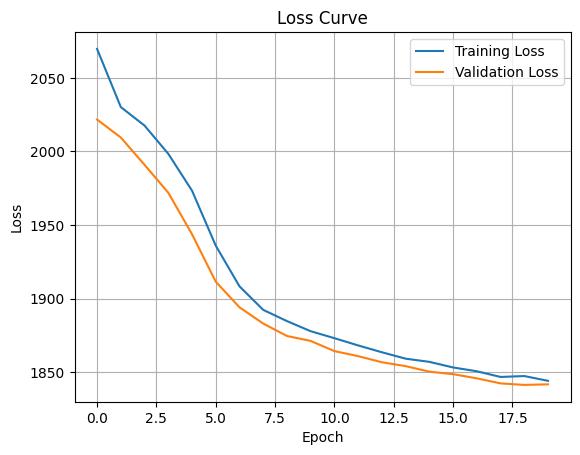

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

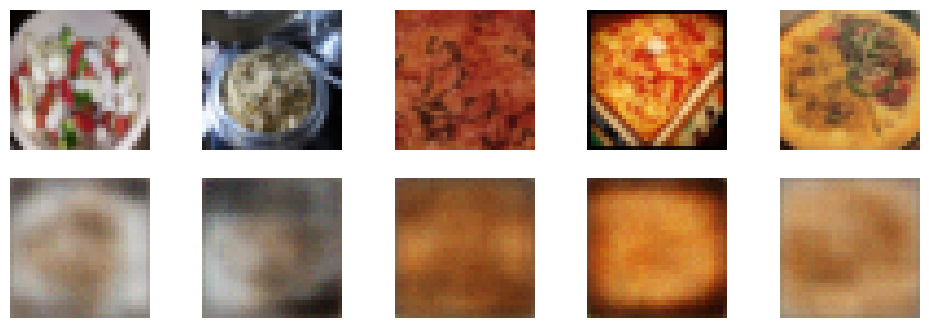

In [ ]:
# testing...
vae.eval()
images, _ = next(iter(vae_test_loader))

with torch.no_grad():
  recon, _, _ = vae(images)


# reconstructing 5 random images...
n = 5
fig, axes = plt.subplots(2, n, figsize=(12,4))

for i in range(n):
  axes[0, i].imshow(images[i].permute(1,2,0).cpu().numpy())
  axes[0, i].axis('off')
  axes[1, i].imshow(recon[i].permute(1,2,0).cpu().numpy())
  axes[1, i].axis('off')

plt.show()


## Part2: Making the GAN...

In [ ]:
# creating datasloaders...
gan_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.ToTensor(),

  # scaling to [-1,1] because we use tanh...
  # the reason i am using tanh is because it is centered at 0, which helps with training stability
  transforms.Normalize([0.5]*3, [0.5]*3)
])


gan_dataset = datasets.ImageFolder(root=data, transform=gan_transform)

trainSize = int(0.8 * len(gan_dataset))
testSize = len(gan_dataset) - trainSize

gan_train, gan_test = random_split(gan_dataset, [trainSize, testSize])
gan_train_loader = DataLoader(gan_train, batch_size=16, shuffle=True)
gan_test_loader = DataLoader(gan_test, batch_size=16, shuffle=False)

In [ ]:
# Generator initialization...
# takes random noise vector as input and outputs an image of size 3 x 32 x 32
class Generator(nn.Module):
  def __init__(self, z_dim=100):
    super(Generator, self).__init__()

    self.net = nn.Sequential(
      # 1 x 1 --> 4 x 4
      nn.ConvTranspose2d(z_dim, 256, 4, 1, 0),
      nn.BatchNorm2d(256),
      nn.ReLU(True),

      # 4 x 4 --> 8 x 8
      nn.ConvTranspose2d(256, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.ReLU(True),

      # 8 x 8 --> 16 x 16
      nn.ConvTranspose2d(128, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(True),

      # 16 x 16 -> 32 x 32
      nn.ConvTranspose2d(64, 3, 4, 2, 1),

      # nonlinear activation function used is tan, so output is bounded to [-1,1]
      nn.Tanh()
    )


  def forward(self, z):
    x = self.net(z)

    if False:
      print("Generator output:", x.shape)
    return x


In [ ]:
# Discriminator initialization...
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.net = nn.Sequential(
      # 32 x 32 --> 16 x 16
      nn.Conv2d(3, 64, 4, 2, 1),
      nn.LeakyReLU(0.2, inplace=True),

      # 16 x 16 --> 8 x 8
      nn.Conv2d(64, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),

      # 8 x 8 --> 4 x 4
      nn.Conv2d(128, 256, 4, 2, 1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      # 4 x 4 --> 1 x 1
      nn.Conv2d(256, 1, 4, 1, 0),

      # nn.AdaptiveAvgPool2d(1),
      nn.Sigmoid()
    )

  def forward(self, x):
    if False:
      print("Discriminator input:", x.shape)

    return self.net(x).view(-1, 1)

In [ ]:
z_dim = 100
G = Generator(z_dim)
D = Discriminator()
criterion = nn.BCELoss()
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

gen_losses = []
disc_losses = []
num_epochs = 20


for epoch in range(num_epochs):
  gen_loss = 0
  disc_loss = 0

  for real_images, _ in gan_train_loader:
    batch_size = real_images.size(0)
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # training discriminator...
    z = torch.randn(batch_size, z_dim, 1, 1)
    fake_images = G(z).detach()
    real_out = D(real_images)
    fake_out = D(fake_images)

    loss_D = criterion(real_out, real_labels) + criterion(fake_out, fake_labels)
    optim_D.zero_grad()
    loss_D.backward()
    optim_D.step()

    disc_loss += loss_D.item()


    # training generator...
    z = torch.randn(batch_size, z_dim, 1, 1)
    fake_images = G(z)
    fake_out = D(fake_images)
    loss_G = criterion(fake_out, real_labels)

    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    gen_loss += loss_G.item()


  # calculating / storing losses...
  avg_gen_loss = gen_loss / len(gan_train_loader)
  avg_disc_loss = disc_loss / len(gan_train_loader)
  gen_losses.append(avg_gen_loss)
  disc_losses.append(avg_disc_loss)

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {avg_disc_loss:.4f}, Loss G: {avg_gen_loss:.4f}")


Epoch [1/20], Loss D: 0.2916, Loss G: 6.1949
Epoch [2/20], Loss D: 0.0677, Loss G: 6.2751
Epoch [3/20], Loss D: 0.3569, Loss G: 4.9799
Epoch [4/20], Loss D: 0.6009, Loss G: 3.4361
Epoch [5/20], Loss D: 0.6035, Loss G: 3.5232
Epoch [6/20], Loss D: 0.4812, Loss G: 3.8528
Epoch [7/20], Loss D: 0.4735, Loss G: 3.4559
Epoch [8/20], Loss D: 0.5670, Loss G: 3.6287
Epoch [9/20], Loss D: 0.6705, Loss G: 3.3752
Epoch [10/20], Loss D: 0.6591, Loss G: 3.1558
Epoch [11/20], Loss D: 0.5773, Loss G: 2.8766
Epoch [12/20], Loss D: 0.6793, Loss G: 2.9365
Epoch [13/20], Loss D: 0.6460, Loss G: 3.1171
Epoch [14/20], Loss D: 0.6169, Loss G: 2.9569
Epoch [15/20], Loss D: 0.6895, Loss G: 2.7058
Epoch [16/20], Loss D: 0.6844, Loss G: 2.5256
Epoch [17/20], Loss D: 0.6939, Loss G: 2.4295
Epoch [18/20], Loss D: 0.6631, Loss G: 2.4860
Epoch [19/20], Loss D: 0.6042, Loss G: 2.4872
Epoch [20/20], Loss D: 0.6904, Loss G: 2.5770


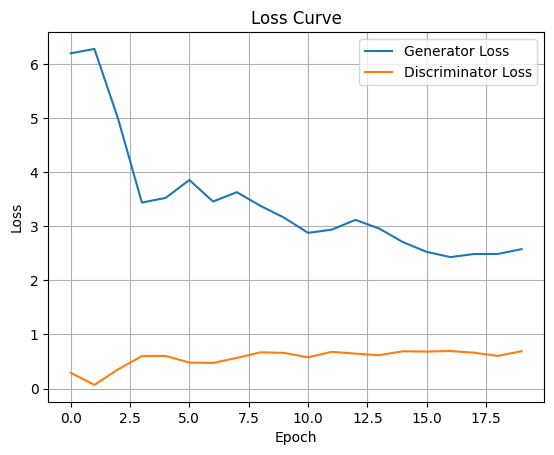

In [ ]:
# plotting loss...
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

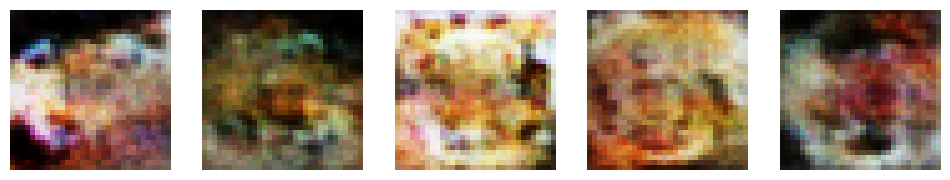

In [ ]:
G.eval()

# testing...
n = 5

with torch.no_grad():
  z = torch.randn(n, z_dim, 1, 1)
  fake_images = G(z).cpu()

# we used tanh as our nonlinear activaiton, so we need to unnormalize [-1,1] -> [0,1]...
fake_images = (fake_images + 1) / 2


# plotting...
fig, axes = plt.subplots(1, n, figsize=(12, 4))
for i in range(n):
    axes[i].imshow(fake_images[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
plt.show()


---
# Task3...

## Part1: Scaled Dot Product Attention Implementation...


In [ ]:
# takes in the query, key, and value matrices and outputs the attention...
class ScaledDotProductAttention(tf.keras.layers.Layer):
  def call(self, query, key, value):
    # Q K dot product...
    matmul_qk = tf.matmul(query, key, transpose_b=True)


    # scaling the dot product... prevents saturation
    dimK = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dimK)


    # applying softmax to get attention weights...

    # represents how revelant each token is in the current query...
    weights = tf.nn.softmax(scaled_scores, axis=-1)

    # weighted sum of value vectors based on the attention...
    output = tf.matmul(weights, value)

    return output, weights

## Part2: Encoder-Decoder Seq2Seq model...

Using LSTMs...

In [ ]:
# encoder initialization...
#
# high level overview:
# we take as input a bunch of tokens, and then we get a vector representation of
# that with the embedding...
# then what the lstm does is at each time step, it embeds the current input, and then
# keeps track of the hidden state, hidden cell (short term memory), and a sequence of
# all the hidden states it has seen up until that time step (long term memory)
#
# the encoder's job is to encode the input, in which it makes a hidden representation
# of the input
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(enc_units, return_sequences=True, return_state=True)

  def call(self, x):
    # take raw tokens --> vector representation...
    x = self.embedding(x)

    # the lstm outputs final hidden state, final cell state, and the output which is the
    #   full sequence of hidden states at each time step...
    output, state_h, state_c = self.lstm(x)
    return output, state_h, state_c

In [ ]:
# decoder initialization...
#
# high level overview:
# we take as input a bunch of tokens AND the final hidden and cell states of the encoder
# then what the lstm does is at each time step, it embeds the current input, and then
# comes up with its own hidden representation of the input + the encoder's final output
#
# with the final decoder output, we then compute attention on it to understand what are the
# most important tokens in the input
#
# the decoder's job is to come up with a hidden representation of the input at each step
# such that we are predicting the next word to output
#
# finally, we then take the final hidden representation of the decoder and add the attention
# so that we can produce an output sentence
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(dec_units, return_sequences=True, return_state=True)
    self.fc = Dense(vocab_size, activation='softmax')

    self.attention = ScaledDotProductAttention()

  def call(self, x, enc_output, state_h, state_c):
    # take raw tokens --> vector representation...
    x = self.embedding(x)

    # the inputs of the DECODER are the outputs of the ENCODER
    dec_output, dec_state_h, dec_state_c = self.lstm(x, initial_state=[state_h, state_c])


    # calculating attention...
    context_vector, attention_weights = self.attention(dec_output, enc_output, enc_output)


    # combining attention with decoder final hidden state...
    combined = tf.concat([context_vector, dec_output], axis=-1)


    output = self.fc(combined)

    return output, dec_state_h, dec_state_c, attention_weights


## Part3: Training the model...

### Preprocessing the Data...

In [ ]:
# the dataset that i have chosen to use is from tatoeba
dataset = load_dataset("Verah/tatoeba_dedupe_en-jp_2024-March-01", split="train")

for i in range(5):
  print(dataset[i])

# the translations are actually not too terrible... nice!

README.md:   0%|          | 0.00/277 [00:00<?, ?B/s]

tatoeba_dedupe_random_en-jp_2024-03-01.t(…):   0%|          | 0.00/8.70M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/201607 [00:00<?, ? examples/s]

{'id': 1, 'english': 'While in England I often consulted the guidebook.', 'japanese': 'イギリスにいる間、私はよくそのガイドブックを参考にした。'}
{'id': 2, 'english': 'Look at the sports car over there.', 'japanese': 'あそこのスポーツカーを見なさい。'}
{'id': 3, 'english': 'Never did I expect that he would fail the examination.', 'japanese': '彼が試験に失敗するなんて私は予想もしなかった。'}
{'id': 4, 'english': 'He knows no foreign language except English.', 'japanese': '彼は英語以外の外国語は全く知らない。'}
{'id': 5, 'english': 'All their secrets have been revealed.', 'japanese': '彼らの秘密が全部暴かれた。'}


In [ ]:
# going from en --> jp sentences for my machine translation task...

allSrcSen = [i["english"] for i in dataset]
allTgtSen = [i["japanese"] for i in dataset]

In [ ]:
# only want to select a subset of the dataset...
srcSen = allSrcSen[:1000]
tgtSen = allTgtSen[:1000]

In [ ]:
# tokenizing...
# so what this is doing is it first takes the sentences and then builds the vocab
# from it. it then uses this vocab to actual "map" each sequence's word with its
# respective token in the vocab
#
# we then finally pad at the end to ensure that all the lists of tokens are the same
# length. the reason we need this is for when we embed, we need dimensions to line up
source_tokenizer = Tokenizer()
source_tokenizer.fit_on_texts(srcSen)
source_sequences = source_tokenizer.texts_to_sequences(srcSen)
source_sequences = pad_sequences(source_sequences, padding='post')


# this is the same process done on the target sentences except for the inclusion
# of start and end...
#
# the reason we have "start" and "end" explicitly here is because the target sentences
# handle both decoder input for predicting its output as well as the ground truth output
# so the "start" tells the decoder to start predicting
# and the "end" tells the model that this is where its ground truth stops
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in tgtSen]
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_sentences)
target_sequences = target_tokenizer.texts_to_sequences(target_sentences)
target_sequences = pad_sequences(target_sequences, padding='post')

In [ ]:
# 80 20 train test split...
X_train, X_tmp, y_train, y_tmp = train_test_split(source_sequences, target_sequences, test_size=0.2)

X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

print(f'Train length: {X_train.shape[0]}')
print(f'Validation length: {X_val.shape[0]}')
print(f'Test length: {X_test.shape[0]}')

Train length: 800
Validation length: 100
Test length: 100


In [ ]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

### Running the Train Loop...

In [ ]:
def loss_function(real, pred):
  # we dont want to calculate padding in our loss, since its not a "real" part...
  mask = tf.math.not_equal(real, 0)


  # get the loss...
  loss_ = loss_object(real, pred)


  # apply mask...
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# training loop...
@tf.function
def train_step(src_seq, tgt_seq):
  loss = 0


  # gradient tape allows ua to record operations to compute the gradients automatically...
  #   (everything here gets called when we call tape.gradient)
  with tf.GradientTape() as tape:
    # getting encoder outputs...
    enc_output, enc_hidden_h, enc_hidden_c = encoder(src_seq)


    # encoder outputs --> decoder inputs...
    dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c


    # we exclude the last token in the decoder input since that is the eos
    dec_input = tgt_seq[:, :-1]

    # the real target sequence... we exclude the first token since that is the sos
    real = tgt_seq[:, 1:]


    # getting decoder outputs...
    pred, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, enc_output, dec_hidden_h, dec_hidden_c)


    # now calculating loss...
    loss = loss_function(real, pred)


  # updating encoder and decoder based on gradients...
  # these variables include: embedding, LSTM, and the dense layers
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss

In [ ]:
# validation loop...
@tf.function
def val_step(src_seq, tgt_seq):
  loss = 0

  enc_output, enc_hidden_h, enc_hidden_c = encoder(src_seq)
  dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
  dec_input = tgt_seq[:, :-1]
  real = tgt_seq[:, 1:]

  pred, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, enc_output, dec_hidden_h, dec_hidden_c)

  loss = loss_function(real, pred)

  return loss

In [ ]:
# initializing the model...

# +1 to account for padding token...
vocab_size_src = len(source_tokenizer.word_index) + 1
vocab_size_tgt = len(target_tokenizer.word_index) + 1

embedding_dim = 256
units = 512

encoder = Encoder(vocab_size_src, embedding_dim, units)
decoder = Decoder(vocab_size_tgt, embedding_dim, units)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
# training...
num_epochs = 10
batch_size = 32

train_losses = []
val_losses = []
iniTime = time.time()

for epoch in range(num_epochs):
  # training...
  total_loss = 0
  avg_train_loss = 0

  for batch in range(len(X_train) // batch_size):
    batch_X = X_train[batch * batch_size: (batch + 1) * batch_size]
    batch_y = y_train[batch * batch_size: (batch + 1) * batch_size]
    batch_loss = train_step(batch_X, batch_y)
    total_loss += batch_loss

  avg_train_loss = total_loss / len(X_train)

  train_losses.append(avg_train_loss)


  # validation...
  total_val_loss = 0
  avg_val_loss = 0

  for batch in range(len(X_val) // batch_size):
    batch_X = X_val[batch * batch_size: (batch + 1) * batch_size]
    batch_y = y_val[batch * batch_size: (batch + 1) * batch_size]
    batch_loss = val_step(batch_X, batch_y)
    total_val_loss += batch_loss

  avg_val_loss = total_val_loss / len(X_val)

  val_losses.append(avg_val_loss)
  print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

finTime = time.time()
print(f'Total Training Time: {finTime - iniTime}')

Epoch 1, Train Loss: 0.0987427681684494, Validation Loss: 0.08545572310686111
Epoch 2, Train Loss: 0.07489000260829926, Validation Loss: 0.09411218017339706
Epoch 3, Train Loss: 0.07231855392456055, Validation Loss: 0.09711357206106186
Epoch 4, Train Loss: 0.07138358801603317, Validation Loss: 0.0978274792432785
Epoch 5, Train Loss: 0.07043653726577759, Validation Loss: 0.09929604828357697
Epoch 6, Train Loss: 0.06875565648078918, Validation Loss: 0.10388955473899841
Epoch 7, Train Loss: 0.06734540313482285, Validation Loss: 0.1060054674744606
Epoch 8, Train Loss: 0.06591993570327759, Validation Loss: 0.1151447594165802
Epoch 9, Train Loss: 0.06567588448524475, Validation Loss: 0.11134412884712219
Epoch 10, Train Loss: 0.06584442406892776, Validation Loss: 0.12052328139543533
Total Training Time: 260.9096541404724


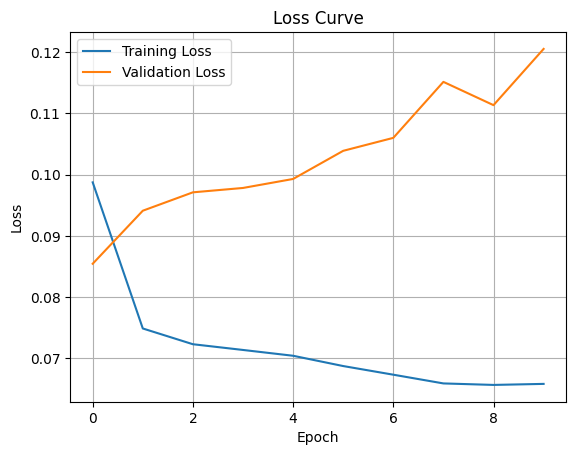

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

### Evaluating Test Set...

In [ ]:
# defining our metrics...
def calculate_bleu(reference, candidate):
  reference = [reference.split()]
  candidate = candidate.split()
  smoothing = SmoothingFunction().method4
  return sentence_bleu(reference, candidate, smoothing_function=smoothing)

def calculate_perplexity(loss):
  return math.exp(loss)

In [ ]:
# testing...
test_sentence = X_test[0:1]


# prediction...
enc_output, enc_hidden_h, enc_hidden_c = encoder(test_sentence)
dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
dec_input = np.array([[target_tokenizer.word_index['start']]])

predicted_sentence = []
for t in range(y_test.shape[1]):
  pred, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, enc_output, dec_hidden_h, dec_hidden_c)
  pred_id = np.argmax(pred[0, -1, :])
  predicted_sentence.append(pred_id)
  if pred_id == target_tokenizer.word_index['end']:
    break
  dec_input = np.array([[pred_id]])


predicted_sentence = ' '.join([target_tokenizer.index_word[i] for i in predicted_sentence if i in target_tokenizer.index_word])
reference_sentence = ' '.join([target_tokenizer.index_word[i] for i in y_test[0] if i in target_tokenizer.index_word])

bleu_score = calculate_bleu(reference_sentence, predicted_sentence)
perplexity = calculate_perplexity(total_loss / len(X_test))

print(f'Predicted: {predicted_sentence}')
print(f'Reference: {reference_sentence}')
print(f'BLEU Score: {bleu_score}')
print(f'Perplexity: {perplexity}')

Predicted: 私たちの仲間に入りなさい。 end
Reference: start もう一度会いに来て。 end
BLEU Score: 0.04096772609215166
Perplexity: 1.693428873267151


Analysis

The BlEU score is between 0 - 1, with 1 meaning that the predicted and ground truth sentences are very similar.

So, the fact that our BLEU score is .04 means that our model was not very accurate.
This makes sense, since reading the outputs myself, the predicted sentence has no similarity at all to the referenced sentence.

The perplexity score measures how "confused" the model was when predicting the next word. A score of 1 means the model was quite confident and accurate.
This makes sense since the actual predicted sentence, while not "accurate" in the sense that it is not similar to the referenced sentence, it is a japanese sentence that makes sense.


The results show that the model was good at learning how to produce valid japanese sentences but was not good at imitating the reference sentence. perhaps one thing that could be done to increase this BLEU score is to train the model on more epochs or increase the subset of the dataset that i am using, since i am only using 1k. the main reason why i had such low training is because

In [ ]:
predicted_sentence

'私たちの仲間に入りなさい。 end'

## Part4: Transformer from Scratch...


### Making the Transformer Architecture...

In [ ]:
# positional encoding...
#
# transformers process the input tokens in parallel, so it doesnt keep track of
# the significance of each token's position. therefore, we have to implement a
# positioning system since position matters for NLP...
def positional_encoding(position, d_model):
  angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

In [ ]:
# this module is responsible for taking the embedded input (it is not doing any
# embedding itself), and then computes the attention.
#
# it first creates the q,k,v matrices, computes the scaled dot product attention
# in parallel (for each head), then concatenates, and returns the output as one
# vector per token
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    # we want to ensure that we can split the embedding dim into the evenly across heads...
    assert d_model % num_heads == 0

    self.depth = d_model // num_heads


    # initializing our q,k,v matrices for attention...
    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)
    self.dense = Dense(d_model)


  # splits input tensor into multiple heads...
  # resulting size is (batch_size, num_heads, seq_len, depth)
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])


  # takes in the query, key, and value matrices and outputs the attention...
  def scaled_dot_product_attention(self, query, key, value, mask):
    # Q K dot product...
    matmul_qk = tf.matmul(query, key, transpose_b=True)


    # scaling the dot product... prevents saturation
    dimK = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dimK)


    # this will be used for the masked multi head attention module in the decoder...
    if mask is not None:
      scaled_scores += (mask * -1e9)


    # applying softmax to get attention weights...

    # represents how revelant each token is in the current query...
    weights = tf.nn.softmax(scaled_scores, axis=-1)

    # weighted sum of value vectors based on the attention...
    output = tf.matmul(weights, value)

    return output, weights


  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]

    # q,k,v matrices...
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)


    # computing the attention...
    scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)


    # concatenating the head outputs...
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))


    output = self.dense(concat_attention)

    return output

In [ ]:
# after getting the input input representation from multi-head attention block,
# the feedforward network transforms the representation of each token independently
#
# it applies nonlinear activation, in this case, relu, and is a regular neural network
# takes input of len of embedding dim --> len of hidden dim --> len of embedding dim
class PositionwiseFeedforward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff):
    super(PositionwiseFeedforward, self).__init__()
    self.d_model = d_model
    self.dff = dff
    self.dense1 = Dense(dff, activation='relu')
    self.dense2 = Dense(d_model)

  def call(self, x):
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [ ]:
# puts together the "left" block of the diagram (only one layer)...
#
# initializes the attention and feed forward network
# and then also is responsible for the adding and normalizing...
#
# this block is one layer of the encoder
class TransformerBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadAttention(d_model, num_heads)
    self.ffn = PositionwiseFeedforward(d_model, dff)
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(dropout_rate)
    self.dropout2 = Dropout(dropout_rate)


  def call(self, x, training, mask):
    attn_output = self.att(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)

    # this is where the adding and normalizing are happening...
    out1 = self.layernorm1(x + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    # adding and normalizing again...
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [ ]:
# this is the full left side of the diagram, which initializes most importantly,
# the number of transformer block layers to be used...
#
# it is also responsible for taking in the raw input, embedding it, then applying
# positional encoding to it
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dropout = Dropout(dropout_rate)
    self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]


  def call(self, x, training, mask):
    # embedding the raw input...
    seq_len = tf.shape(x)[1]
    x = self.embedding(x)


    # applying the positional encoding...
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)


    # now, running through the entire transformerblock module (one pass of the left side)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training=training, mask=mask)
    return x

In [ ]:
# puts together the "right" block of the diagram (only one layer)...
#
# initializes most importantly, the masked multihead attention,
# the crossed multihead attentionm, and the feedforward network
#
# it is also responsible for the adding and norming after each module
class DecoderBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    # masked self-attn
    self.mha1 = MultiHeadAttention(d_model, num_heads)

    # cross attention: encoder-decoder attention
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    # feedforward network
    self.ffn  = PositionwiseFeedforward(d_model, dff)

    self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.drop1 = tf.keras.layers.Dropout(dropout_rate)
    self.drop2 = tf.keras.layers.Dropout(dropout_rate)
    self.drop3 = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # masked self-attention: q=k=v=x
    attn1 = self.mha1(x, x, x, mask=look_ahead_mask)
    out1 = self.norm1(x + self.drop1(attn1, training=training))

    # cross-attention: q=out1, k=v=enc_output
    attn2 = self.mha2(enc_output, enc_output, out1, mask=padding_mask)
    out2 = self.norm2(out1 + self.drop2(attn2, training=training))

    # position-wise feedforward network
    ffn_out = self.ffn(out2)
    out3 = self.norm3(out2 + self.drop3(ffn_out, training=training))
    return out3


In [ ]:
# this is the full right side of the diagram, which initializes most importantly,
# the number of decoder block layers to be used...
#
# this module embeds the output, it then positionally encodes it, performs
# masked multihead attention, then does cross multihead attention with the encoder
# outputs + the masked multihead attention, it then finally passes it through a
# neural network
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dropout = Dropout(dropout_rate)
    self.dec_layers = [DecoderBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # output embedding...
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    x = self.embedding(x)


    # positional encoding...
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)


    # now running through the entire right side (one layer at a time)
    for layer in self.dec_layers:
        x = layer(x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
    return x, attention_weights

In [ ]:
# puts everything together...
#
# initializes the decoder, encoder, and the final neural network...
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super(Transformer, self).__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate)
    self.final_layer = Dense(target_vocab_size)


  def call(self, inputs, training=False, look_ahead_mask=None, padding_mask=None):
    inp, tar = inputs

    # get encoder output...
    enc_output = self.encoder(inp, training=training, mask=padding_mask)


    # feed it as decoder input + actual input...
    dec_output, _ = self.decoder(tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)


    # feed it into the final neural network...
    final_output = self.final_layer(dec_output)

    return final_output

### Preprocessing the Data...

Mainly, just increasing the subset from 1k to 10k, since transformers need much more data...

In [ ]:
# the dataset that i have chosen to use is from tatoeba
dataset = load_dataset("Verah/tatoeba_dedupe_en-jp_2024-March-01", split="train")

for i in range(5):
  print(dataset[i])

# the translations are actually not too terrible... nice!

{'id': 1, 'english': 'While in England I often consulted the guidebook.', 'japanese': 'イギリスにいる間、私はよくそのガイドブックを参考にした。'}
{'id': 2, 'english': 'Look at the sports car over there.', 'japanese': 'あそこのスポーツカーを見なさい。'}
{'id': 3, 'english': 'Never did I expect that he would fail the examination.', 'japanese': '彼が試験に失敗するなんて私は予想もしなかった。'}
{'id': 4, 'english': 'He knows no foreign language except English.', 'japanese': '彼は英語以外の外国語は全く知らない。'}
{'id': 5, 'english': 'All their secrets have been revealed.', 'japanese': '彼らの秘密が全部暴かれた。'}


In [ ]:
# going from en --> jp sentences for my machine translation task...

allSrcSen = [i["english"] for i in dataset]
allTgtSen = [i["japanese"] for i in dataset]

In [ ]:
# only want to select a subset of the dataset...
srcSen = allSrcSen[:10000]
tgtSen = allTgtSen[:10000]

In [ ]:
# tokenizing...
# so what this is doing is it first takes the sentences and then builds the vocab
# from it. it then uses this vocab to actual "map" each sequence's word with its
# respective token in the vocab
#
# we then finally pad at the end to ensure that all the lists of tokens are the same
# length. the reason we need this is for when we embed, we need dimensions to line up
source_tokenizer = Tokenizer()
source_tokenizer.fit_on_texts(srcSen)
source_sequences = source_tokenizer.texts_to_sequences(srcSen)
source_sequences = pad_sequences(source_sequences, padding='post')


# this is the same process done on the target sentences except for the inclusion
# of start and end...
#
# the reason we have "start" and "end" explicitly here is because the target sentences
# handle both decoder input for predicting its output as well as the ground truth output
# so the "start" tells the decoder to start predicting
# and the "end" tells the model that this is where its ground truth stops
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in tgtSen]
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_sentences)
target_sequences = target_tokenizer.texts_to_sequences(target_sentences)
target_sequences = pad_sequences(target_sequences, padding='post')

In [ ]:
target_tokenizer.word_index['end']

2

In [ ]:
# 80 20 train test split...
X_train, X_tmp, y_train, y_tmp = train_test_split(source_sequences, target_sequences, test_size=0.2)

X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

print(f'Train length: {X_train.shape[0]}')
print(f'Validation length: {X_val.shape[0]}')
print(f'Test length: {X_test.shape[0]}')

Train length: 8000
Validation length: 1000
Test length: 1000


In [ ]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

### Training...

In [ ]:
def loss_function(real, pred):
  # we dont want to calculate padding in our loss, since its not a "real" part...
  pad_mask = tf.math.not_equal(real, 0)
  eos_mask = tf.math.not_equal(real, target_tokenizer.word_index['end'])
  mask = tf.math.logical_and(pad_mask, eos_mask)  # exclude pad and eos

  # get the loss...
  loss_ = loss_object(real, pred)


  # apply mask...
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_stepTransformer(src_seq, tgt_seq):
  loss = 0

  with tf.GradientTape() as tape:
    pred = transformer((src_seq, tgt_seq[:, :-1]), training=True, look_ahead_mask=None, padding_mask=None)

    real = tgt_seq[:, 1:]
    loss = loss_function(real, pred)

  variables = transformer.trainable_variables
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  return loss

In [ ]:
@tf.function
def val_stepTransformer(src_seq, tgt_seq):
  loss = 0

  pred = transformer((src_seq, tgt_seq[:, :-1]), training=True, look_ahead_mask=None, padding_mask=None)

  real = tgt_seq[:, 1:]
  loss = loss_function(real, pred)

  return loss

In [ ]:
# Defining Custom Parameters.
num_layers = 2
d_model = 64
num_heads = 2
dff = 128
input_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1
maximum_position_encoding = 10000
dropout_rate = 0.1

transformer = Transformer(
  num_layers,
  d_model,
  num_heads,
  dff,
  input_vocab_size,
  target_vocab_size,
  maximum_position_encoding,
  dropout_rate
)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

look_ahead_mask = None
padding_mask = None


In [ ]:
# training...
num_epochs = 10
batch_size = 32

train_losses = []
val_losses = []
iniTime = time.time()

for epoch in range(num_epochs):
  # training...
  total_loss = 0
  avg_train_loss = 0

  for batch in range(len(X_train) // batch_size):
    batch_X = X_train[batch * batch_size: (batch + 1) * batch_size]
    batch_y = y_train[batch * batch_size: (batch + 1) * batch_size]
    batch_loss = train_stepTransformer(batch_X, batch_y)
    total_loss += batch_loss

  avg_train_loss = total_loss / len(X_train)

  train_losses.append(avg_train_loss)


  # validation...
  total_val_loss = 0
  avg_val_loss = 0

  for batch in range(len(X_val) // batch_size):
    batch_X = X_val[batch * batch_size: (batch + 1) * batch_size]
    batch_y = y_val[batch * batch_size: (batch + 1) * batch_size]
    batch_loss = val_stepTransformer(batch_X, batch_y)
    total_val_loss += batch_loss

  avg_val_loss = total_val_loss / len(X_val)

  val_losses.append(avg_val_loss)
  print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

finTime = time.time()
print(f'Total Training Time: {finTime - iniTime}')

Epoch 1, Train Loss: 0.035923052579164505, Validation Loss: 0.03541051223874092
Epoch 2, Train Loss: 0.03340670093894005, Validation Loss: 0.040078334510326385
Epoch 3, Train Loss: 0.03207097947597504, Validation Loss: 0.043102655559778214
Epoch 4, Train Loss: 0.036746278405189514, Validation Loss: 0.047678396105766296
Epoch 5, Train Loss: 0.03744702786207199, Validation Loss: 0.04896117374300957
Epoch 6, Train Loss: 0.03661952540278435, Validation Loss: 0.04937613755464554
Epoch 7, Train Loss: 0.03624715283513069, Validation Loss: 0.049458097666502
Epoch 8, Train Loss: 0.03602151200175285, Validation Loss: 0.04943501204252243
Epoch 9, Train Loss: 0.03586600720882416, Validation Loss: 0.0493837371468544
Epoch 10, Train Loss: 0.03577515482902527, Validation Loss: 0.04937991499900818
Total Training Time: 910.77476978302


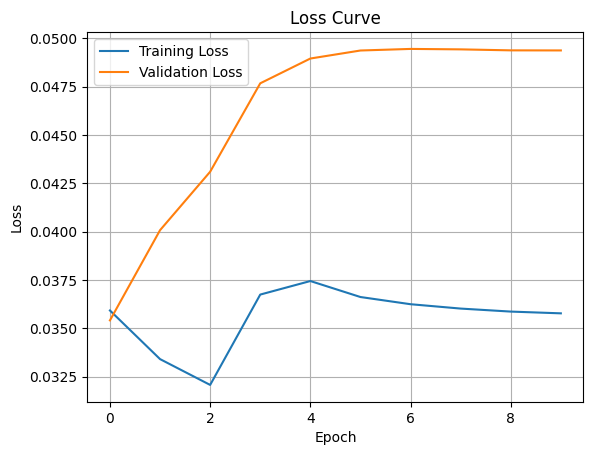

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

### Evaluating Test Set...

In [ ]:
# defining our metrics...
def calculate_bleu(reference, candidate):
  reference = [reference.split()]
  candidate = candidate.split()
  smoothing = SmoothingFunction().method4
  return sentence_bleu(reference, candidate, smoothing_function=smoothing)

def calculate_perplexity(loss):
  return math.exp(loss)

In [ ]:
# testing...
test_sentence = X_test[0:1]


# prediction...
tgt_input = np.array([[target_tokenizer.word_index['start']]])

predicted_sentence = []
for t in range(y_test.shape[1]):

  pred = transformer((test_sentence, tgt_input), training=True, look_ahead_mask=None, padding_mask=None)


  pred_id = np.argmax(pred[0, -1, :])
  predicted_sentence.append(pred_id)
  if pred_id == target_tokenizer.word_index['end']:
    break
  tgt_input = np.array([[pred_id]])


predicted_sentence = ' '.join([target_tokenizer.index_word[i] for i in predicted_sentence if i in target_tokenizer.index_word])
reference_sentence = ' '.join([target_tokenizer.index_word[i] for i in y_test[0] if i in target_tokenizer.index_word])

bleu_score = calculate_bleu(reference_sentence, predicted_sentence)
perplexity = calculate_perplexity(total_loss / len(X_test))

print(f'Predicted: {predicted_sentence}')
print(f'Reference: {reference_sentence}')
print(f'BLEU Score: {bleu_score}')
print(f'Perplexity: {perplexity}')

Predicted: 私が行った日には空席がたくさんあった。 新しいエンジンは必要なテストをすべて受けなければならない。 この歌劇は５幕ものです。 天気は暑いです。 その罪の責任は彼にある。 天気は暑いです。 部屋から大きな音が聞こえていた。 私たちは英語を学びながら、楽しい時間を過ごした。 私はレストランに入って昼食を摂った。
Reference: start やりたくないな。 end
BLEU Score: 0
Perplexity: 1.3313603494317463


Analysis...

When comparing the Transformer results to the Seq2Seq model's results, the transformer performs worse on both the BLEU and Perplexity score.

One thing of interest to note is that the Perplexity score is above 1, which as I've mentoined when analyzing the Seq2Seq results, this represents that the model was very confident at predicting its next word. Personally, this perplexity score does not surprise me. The predicted output the model produces is readable but I can tell its less "natural" at certain parts compared to the Seq2Seq, so I can see why this score was less.

Additionally, the BLEU score was less than the Seq2Seq model, sitting at 0, meaning the model's predictions were not related to the referenced sentence.

I believe maybe one reason is that I would need to have done more training on the transformer. This is because usually transformers require a significant amount of training, both in terms of the data but as well as the number of epochs. Unfortunately, due to resource constraints, it was unrealistic for me to complete a vast majority of training that would be required to produce better results.

In terms of runtime, I used 10x the data subset for the Transformer than the Seq2Seq model, but ran both for the same number of epochs. That is, with the same tatoeba dataset, my Seq2Seq had a 1k subset and my Transformer had 10k. Despite the 10x increase in data to go through, the Transformer took a bit less than double the amount of time than the Seq2Seq model. This suggests that the Transformer is more efficient in terms of runtime as compared to the Seq2Seq.



In [ ]:
predicted_sentence

'私が行った日には空席がたくさんあった。 新しいエンジンは必要なテストをすべて受けなければならない。 この歌劇は５幕ものです。 天気は暑いです。 その罪の責任は彼にある。 天気は暑いです。 部屋から大きな音が聞こえていた。 私たちは英語を学びながら、楽しい時間を過ごした。 私はレストランに入って昼食を摂った。'